# Vorlesung 5: Bayes-Modellvergleich

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import comb, factorial
from scipy.integrate import quad, nquad, dblquad
from scipy.optimize import minimize

## Bayes-Faktoren für den Würfelwurf

In [3]:
def Bayes_Evidenz_Modell_A(n, k, H0 = 0.5):
    return comb(n ,k) * H0**k * (1-H0)**(n-k)

def Bayes_Evidenz_Modell_B(n, k, Prior = lambda H: 1):
    return quad(lambda H: comb(n ,k) * H**k * (1-H)**(n-k) * Prior(H), 0, 1)[0]

def Bayes_Faktor(n, k, Prior_Verhältnis = 1):
    return Bayes_Evidenz_Modell_B(n, k) / Bayes_Evidenz_Modell_A(n, k) * Prior_Verhältnis

def Alle_Ergebnisse(n, k):
    print('Bayes-Evidenz Modell A: ',Bayes_Evidenz_Modell_A(n, k))
    print('Bayes-Evidenz Modell B: ',Bayes_Evidenz_Modell_B(n, k))
    print('Bayes-Faktor: ',Bayes_Faktor(n, k))

In [4]:
Alle_Ergebnisse(100,65)

Bayes-Evidenz Modell A:  0.0008638556657416525
Bayes-Evidenz Modell B:  0.00990099009900986
Bayes-Faktor:  11.461393947690889


In [5]:
Alle_Ergebnisse(100,51)

Bayes-Evidenz Modell A:  0.07802866410507721
Bayes-Evidenz Modell B:  0.009900990099009903
Bayes-Faktor:  0.12688914019695052


## Bayes-Faktoren für Polynom-Fits

### Beispiel 1: Polynom 2. Grades

In [8]:
Wahres_Polynom = lambda x: x**2 - x + 1
Messpunkte = np.arange(-1,1.2,0.2)
Messfehler = np.array([0.2 * Messpunkt**2 + 0.2 for Messpunkt in Messpunkte])
Datenpunkte = np.array([np.random.normal(Wahres_Polynom(Messpunkte[i]), Messfehler[i]) 
                        for i in range(len(Messpunkte))])

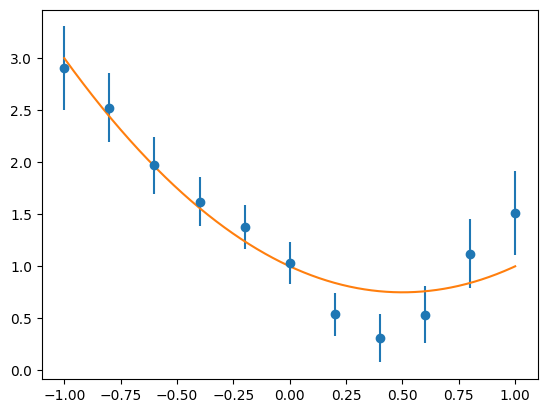

In [9]:
fig = plt.figure()

plt.errorbar(Messpunkte, Datenpunkte, yerr=Messfehler, linestyle='none',fmt='o')
plt.plot(np.linspace(-1,1,1000),Wahres_Polynom(np.linspace(-1,1,1000)))

In [20]:
def LogLikelihood(aj):
    Polynom = lambda x: np.sum([aj[i]*x**i for i in range(len(aj))])
    return np.sum([-(Polynom(Messpunkte[k]) - Datenpunkte[k])**2 / (2 * Messfehler[k]**2)
                  for k in range(len(Messpunkte))])

def Max_LogLikelihood(j = 2):
    result = minimize(lambda x: -2 * LogLikelihood(x), np.ones(j))
    return [result.x, result.fun]

Das Maximum der Likelihood-Funktion wird umso größer, je mehr Parameter im Fit verwendet werden.

For i_max =  0 : log(L_max) =  -39.39209953685946
For i_max =  1 : log(L_max) =  -15.856687507417844
For i_max =  2 : log(L_max) =  -3.9668664330644625
For i_max =  3 : log(L_max) =  -1.2592916743860825
For i_max =  4 : log(L_max) =  -1.0463350775363676
For i_max =  5 : log(L_max) =  -0.6525110119890024
For i_max =  6 : log(L_max) =  -0.04662920045866896


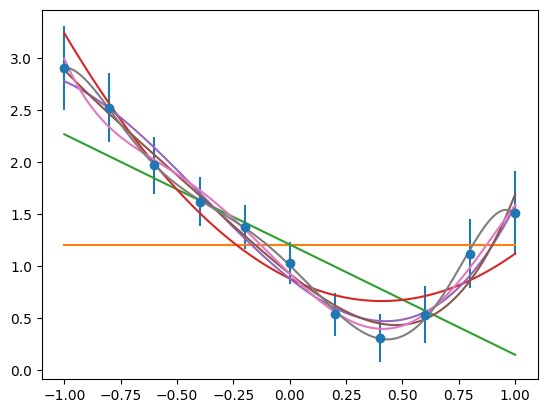

In [21]:
plt.errorbar(Messpunkte, Datenpunkte, yerr=Messfehler, linestyle='none',fmt='o')

for imax in range(7):
    res = Max_LogLikelihood(j = imax + 1)
    print("For i_max = ",imax,": log(L_max) = ", - res[1] / 2.)
    Polynom = lambda x: np.sum([res[0][i] * x**i for i in range(imax + 1)], axis=0)
    
    plt.plot(np.linspace(-1,1,1000),Polynom(np.linspace(-1,1,1000)))

Die Bayes-Evidenz nimmt ab, wenn man zu viele Parameter einführt.

In [24]:
def Bayes_Evidenz(imax = 2, amin = -5., amax = 5.):

    # Numerische Optimierung
    Hilfsarray_1 = [Messpunkte**i / (np.sqrt(2) * Messfehler) for i in range(imax)]
    Hilfsarray_2 = Datenpunkte / (np.sqrt(2) * Messfehler)

    def LogLikelihood(aj):
        return np.sum(-(np.dot(aj,Hilfsarray_1) - Hilfsarray_2)**2)
    
    prior = 1/(amax - amin)**imax

    def integrand(*aj):
        return np.exp(LogLikelihood(aj)) * prior
    
    ranges_full = [[amin, amax] for i in range(imax)]

    options = [{'epsrel': 0.01, 'epsabs': 1e-20} for i in range(imax)]
    
    best_fit = Max_LogLikelihood(j = imax + 1)[0]
    # Zur Beschleunigung der Integration kann man den Integrationsbereich begrenzen
    ranges_fast = [[max(best_fit[i] - abs(best_fit[i]), amin), 
                          min(best_fit[i] + abs(best_fit[i]), amax)] for i in range(imax)]
    
    if(imax < 4):
        result = nquad(integrand, ranges_full, opts=options)
    else:
        result = nquad(integrand, ranges_fast, opts=options)

    return result

In [25]:
for imax in range(4):
    res = Bayes_Evidenz(imax = imax + 1)
    print("For i_max = ",imax,": Bayes-Evidenz = ", res[0], "+/-", res[1])

For i_max =  0 : Bayes-Evidenz =  1.5156526447166305e-19 +/- 4.001959082337449e-21
For i_max =  1 : Bayes-Evidenz =  9.766932743898031e-11 +/- 9.938047744920606e-15
For i_max =  2 : Bayes-Evidenz =  9.508560639577701e-07 +/- 2.952148575428729e-09
For i_max =  3 : Bayes-Evidenz =  1.3745215122336873e-06 +/- 4.149439780558535e-08


Mehrdimensionale Integration sehr langsam. Beschleunigung durch MC-Integration:

In [26]:
def Bayes_Evidenz_MC(imax = 2, amin = -5., amax = 5., N_samples = 1000000):

    # Numerische Optimierung
    Hilfsarray_1 = [Messpunkte**i / (np.sqrt(2) * Messfehler) for i in range(imax)]
    Hilfsarray_2 = Datenpunkte / (np.sqrt(2) * Messfehler)

    def Likelihood(aj):
        return np.exp(np.sum(-(np.dot(aj,Hilfsarray_1) - Hilfsarray_2)**2))
        
    points = np.array([Likelihood(np.random.uniform(low = amin, high = amax, size = imax))
                       for i in range(N_samples)])
    
    return np.sum(points) / N_samples, np.std(points) / np.sqrt(N_samples)

In [27]:
for imax in range(6):
    res = Bayes_Evidenz_MC(imax = imax + 1)
    print("For i_max = ",imax,": Bayes-Evidenz = ", res[0], "+/-", res[1])

For i_max =  0 : Bayes-Evidenz =  1.5060222888549521e-19 +/- 8.980166918952705e-22
For i_max =  1 : Bayes-Evidenz =  1.0013095922740522e-10 +/- 2.5679199147196287e-12
For i_max =  2 : Bayes-Evidenz =  9.323886755279947e-07 +/- 7.92091882441101e-08
For i_max =  3 : Bayes-Evidenz =  1.8261468733762786e-06 +/- 3.4323326116872976e-07
For i_max =  4 : Bayes-Evidenz =  3.123124703415932e-07 +/- 8.119271690570596e-08
For i_max =  5 : Bayes-Evidenz =  1.3935809234787385e-07 +/- 5.034756012113458e-08


### Beispiel 2: Polynom 3. Grades

In [33]:
Wahres_Polynom = lambda x: x**3/3 - x**2/4 + x - 1
Messpunkte = np.arange(-1,1.2,0.2)
Messfehler = np.array([0.2 * Messpunkt**2 + 0.2 for Messpunkt in Messpunkte])
Datenpunkte = np.array([np.random.normal(Wahres_Polynom(Messpunkte[i]), Messfehler[i]) 
                        for i in range(len(Messpunkte))])

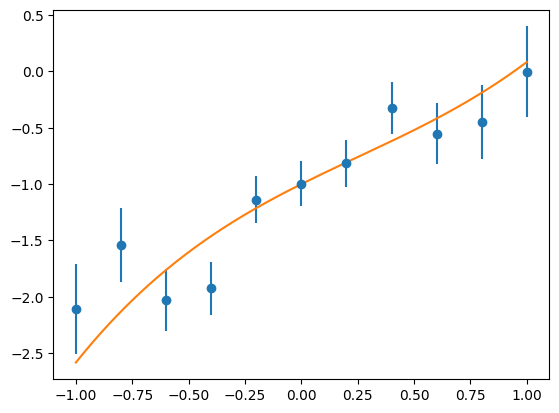

In [34]:
fig = plt.figure()

plt.errorbar(Messpunkte, Datenpunkte, yerr=Messfehler, linestyle='none',fmt='o')
plt.plot(np.linspace(-1,1,1000),Wahres_Polynom(np.linspace(-1,1,1000)))

In [35]:
def Bayes_Evidenz_MC(imax = 2, amin = -5., amax = 5., N_samples = 1000000):

    # Numerische Optimierung
    Hilfsarray_1 = [Messpunkte**i / (np.sqrt(2) * Messfehler) for i in range(imax)]
    Hilfsarray_2 = Datenpunkte / (np.sqrt(2) * Messfehler)

    def Likelihood(aj):
        return np.exp(np.sum(-(np.dot(aj,Hilfsarray_1) - Hilfsarray_2)**2))
        
    points = np.array([Likelihood(np.random.uniform(low = amin, high = amax, size = imax))
                       for i in range(N_samples)])
    
    return np.sum(points) / N_samples, np.std(points) / np.sqrt(N_samples)

In [36]:
for imax in range(6):
    res = Bayes_Evidenz_MC(imax = imax + 1, amin=-2, amax=2)
    print("For i_max = ",imax,": Bayes-Evidenz = ", res[0], "+/-", res[1])

For i_max =  0 : Bayes-Evidenz =  2.3296117582815837e-15 +/- 8.597561709820659e-18
For i_max =  1 : Bayes-Evidenz =  4.345622927025549e-05 +/- 4.4729654570038116e-07
For i_max =  2 : Bayes-Evidenz =  7.651851999071829e-06 +/- 1.6148136153830723e-07
For i_max =  3 : Bayes-Evidenz =  5.290796985592301e-06 +/- 1.8107810801964404e-07
For i_max =  4 : Bayes-Evidenz =  4.068481703771339e-06 +/- 1.687201305894619e-07
For i_max =  5 : Bayes-Evidenz =  2.8777141729601798e-06 +/- 1.5919703470322714e-07


## Bayes-Faktoren für Poisson-Verteilung

### Beispiel: Ereignisse in einem Detektor

In [37]:
Poisson_Likelihood = lambda mu, n: mu**n / factorial(n) * np.exp(-mu)
Beobachtung = 50
mu_A = lambda a: np.exp(a)
mu_B = lambda b, c: (b - c)**2 + 1

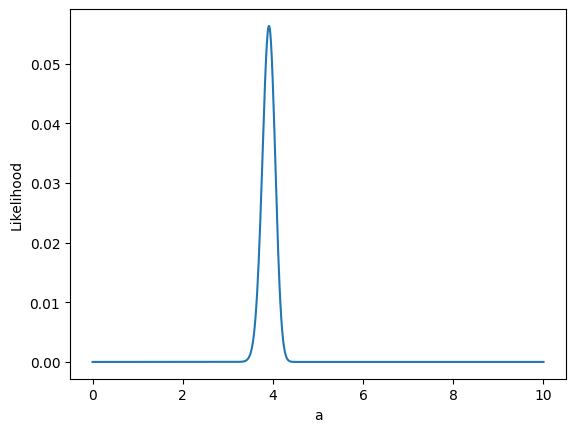

In [38]:
grid = np.linspace(0,10,1000)
L = (Poisson_Likelihood(mu_A(grid),Beobachtung))
plt.xlabel('a')
plt.ylabel('Likelihood')
plt.plot(grid,L)
plt.show()

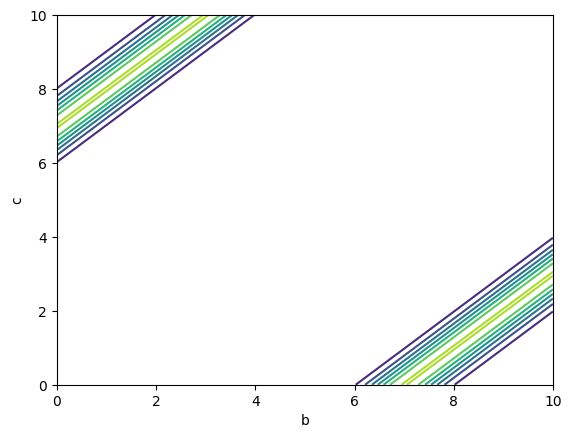

In [39]:
grid = np.linspace(0,10,1000)
L = ([[Poisson_Likelihood(mu_B(b,c),Beobachtung) for b in grid] for c in grid])
plt.contour(grid,grid,L)
plt.xlabel('b')
plt.ylabel('c')
plt.show()

In [40]:
integrand_A = lambda a: Poisson_Likelihood(mu_A(a),Beobachtung) / 10
print('Bayes-Evidenz Modell A: ', quad(integrand_A, 0, 10)[0])
integrand_B = lambda b, c: Poisson_Likelihood(mu_B(b,c),Beobachtung) / 10**2
print('Bayes-Evidenz Modell B: ', nquad(integrand_B, [[0, 10], [0,10]])[0])

Bayes-Evidenz Modell A:  0.0019999999999999888
Bayes-Evidenz Modell B:  0.004251561116097025
